# 0. Importar librerias

In [2]:
#Manejo de datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Encontrar palabras simlares
from difflib import SequenceMatcher

# 1. Cargar Datos

In [13]:
churn_future = pd.read_json('data/churn_future.json')
churn_historic = pd.read_json('data/churn_historic.json')

# 2. Perfilamiento y calidad de datos

In [4]:
churn_historic.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4431,6408-OTUBZ,Female,0,No,No,66,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,No,One year,Yes,Bank transfer (automatic),104.55,6779.05,No
3656,1227-UDMZR,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),91.15,6637.9,No
5528,7623-TRNQN,Male,0,No,Yes,1,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,49.90,49.9,Yes
1726,5858-EAFCZ,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Mailed check,44.45,44.45,No
461,8095-WANWK,Female,0,No,No,10,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Mailed check,45.25,428.7,No


## 2.1 Dimensiones de los datos

In [5]:
print(churn_future.shape, churn_historic.shape)

(1000, 21) (6000, 21)


Se observa que el dataset churn_future que se utilizará más adelante tiene 1000 registros y el archivo churn_historic tiene 6000, lo que es en principio suficiente información para resolver el problema.

## 2.2 Reporte de Nulos

In [6]:
churn_historic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   SeniorCitizen     6000 non-null   int64  
 3   Partner           6000 non-null   object 
 4   Dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   PhoneService      6000 non-null   object 
 7   MultipleLines     6000 non-null   object 
 8   InternetService   6000 non-null   object 
 9   OnlineSecurity    6000 non-null   object 
 10  OnlineBackup      6000 non-null   object 
 11  DeviceProtection  6000 non-null   object 
 12  TechSupport       6000 non-null   object 
 13  StreamingTV       6000 non-null   object 
 14  StreamingMovies   6000 non-null   object 
 15  Contract          6000 non-null   object 
 16  PaperlessBilling  6000 non-null   object 


Vemos que no hay nulos para ninguna variable.

## 2.3 Reporte de Duplicados

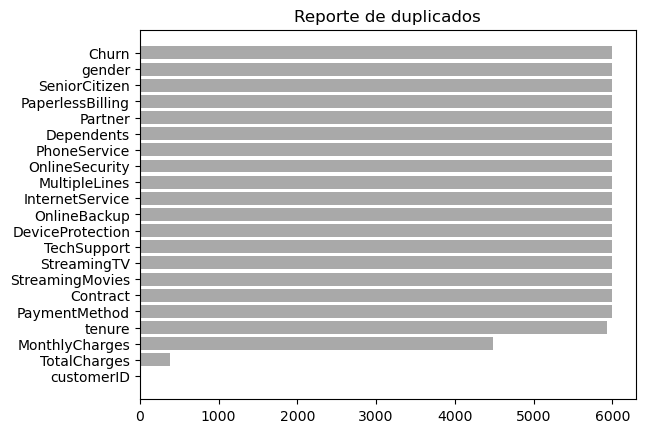

In [7]:
columns = []
duplicates = []
for c in churn_historic:
    columns.append(c)
    duplicates.append(churn_historic[c].duplicated().sum())

df = pd.DataFrame({'columns':columns,'duplicates':duplicates}).sort_values(by=['duplicates'])
plt.title('Reporte de duplicados')
plt.barh(df['columns'].to_list(), df['duplicates'].to_list(), color='darkgrey')
plt.show()

Vemos que hay bastantes duplicados, sin embargo en este caso, no es tan importante para resolver el problema que la mayoría de las columnas tenga duplicados siempre y cuando, como se observa, el customerID no lo esté.

## 2.4 Distribución de las variables

### 2.4.1 Comportamiento de variables Categóricas

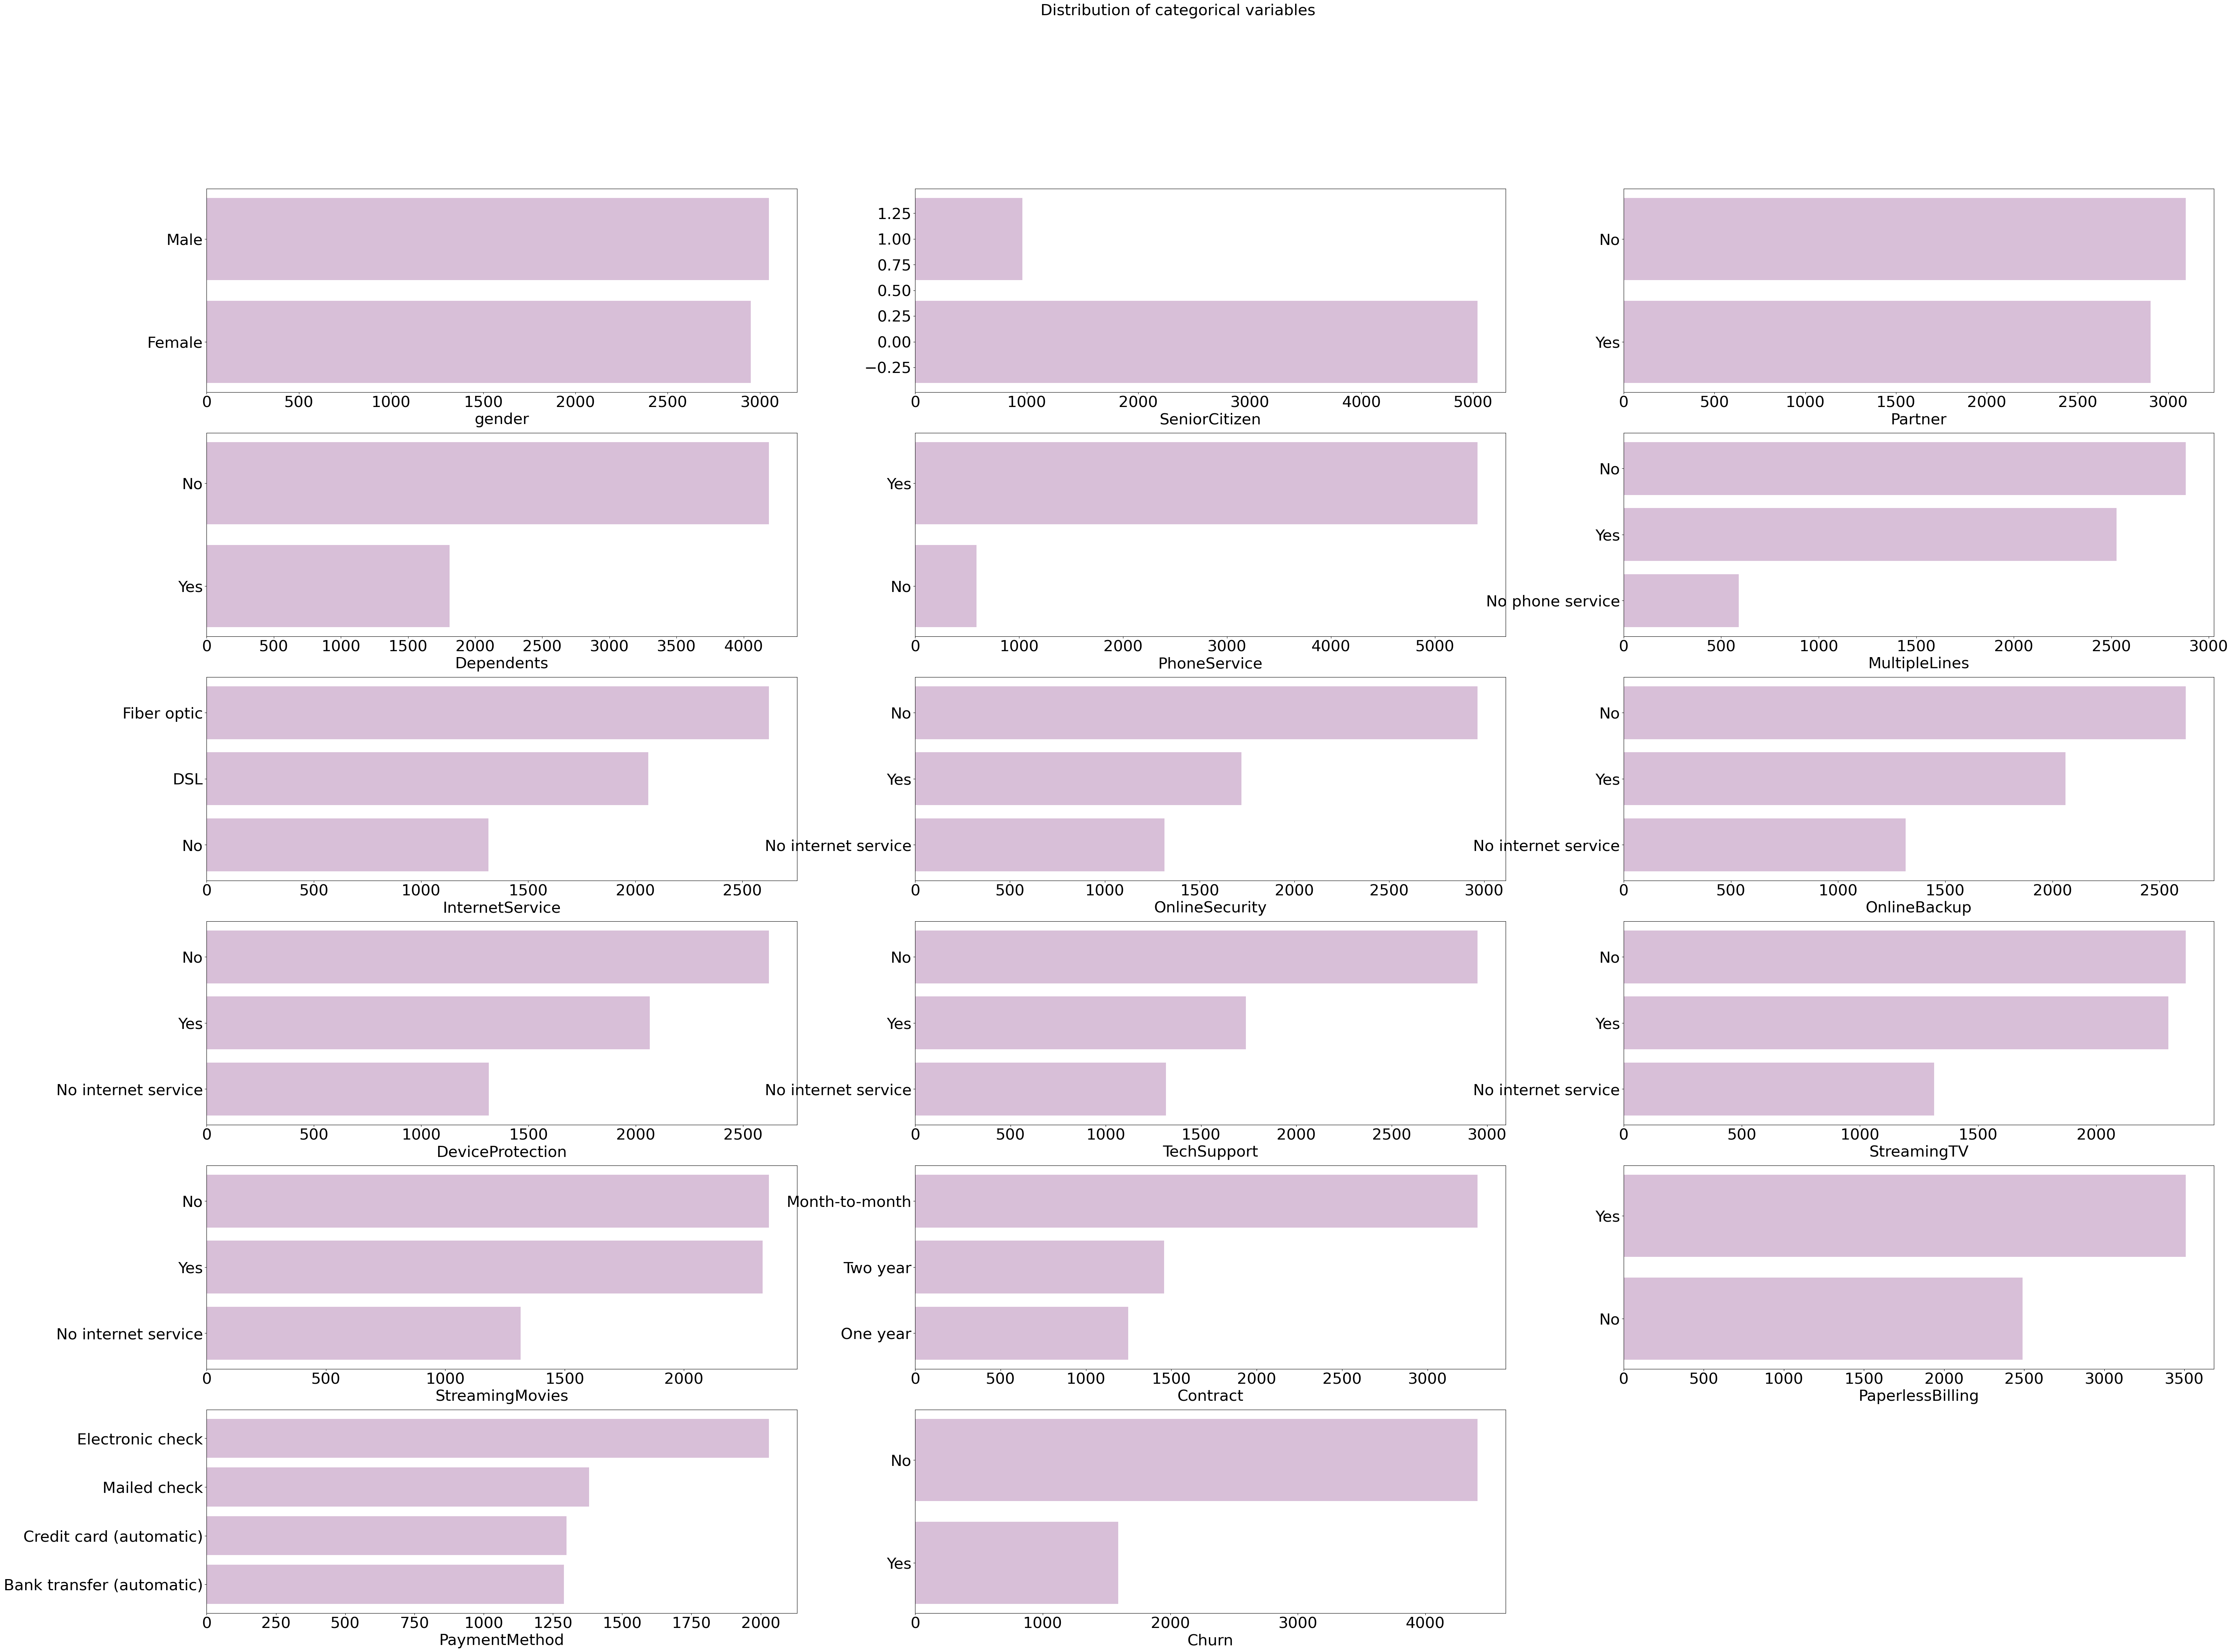

In [8]:
non_categorical_variables = ['TotalCharges', 'tenure', 'MonthlyCharges','customerID']
columns = [i for i in churn_historic.columns if i not in non_categorical_variables]
plt.figure(figsize=(70,50))
plt.suptitle('Distribution of categorical variables',size=30)
for i in range(len(columns)):
    plt.subplot(int(len(columns)/3)+1,3,i+1)
    graph_data = pd.DataFrame()
    graph_data[columns[i]] = churn_historic[columns[i]].copy()
    graph_data = graph_data.groupby(columns[i]).value_counts()
    labels = graph_data.index
    values = graph_data.values
    graph_data=pd.DataFrame({'values':values,'labels':labels}).sort_values(by='values')
    plt.barh(graph_data['labels'],graph_data['values'],color='thistle')
    plt.xlabel(columns[i],size=30)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
plt.show()

### 2.4.2 Comportamiento de variables numéricas

#### 2.4.2.1 Histograma de variables numéricas

In [9]:
churn_historic

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,5386-THSLQ,Female,1,Yes,No,66,No,No phone service,DSL,No,...,Yes,No,Yes,No,One year,No,Bank transfer (automatic),45.55,3027.25,No
4,3192-NQECA,Male,0,Yes,No,68,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),110.00,7611.85,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4933-BSAIP,Female,0,Yes,No,40,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.10,780.1,No
5996,2030-BTZRO,Male,0,Yes,Yes,6,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),20.40,107.6,No
5997,1116-DXXDF,Male,0,No,No,39,Yes,No,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,Yes,Electronic check,100.45,3801.7,No
5998,9274-CNFMO,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,No,Electronic check,74.95,308.7,Yes


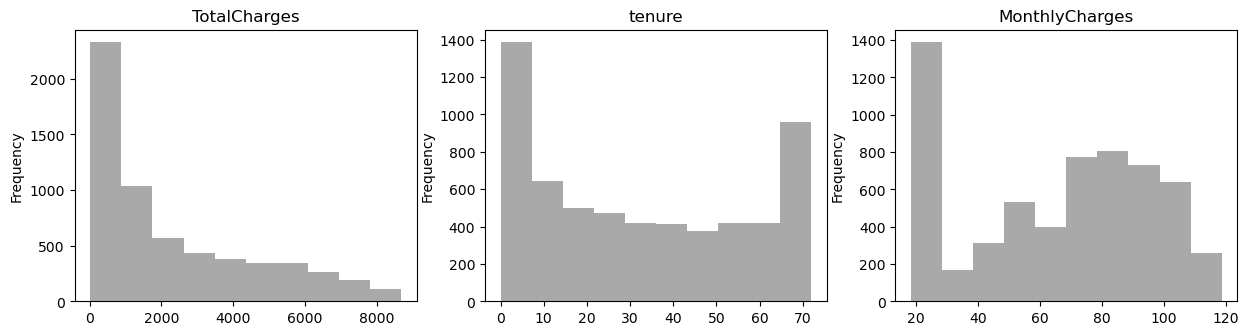

In [10]:
numerical_variables = ['TotalCharges', 'tenure', 'MonthlyCharges']
def parse_charges_float(x):
    if type(x)== str:
        if len(x) > 0:
              return float(x)
        else:
              return np.nan
    else:
        return x

plt.figure(figsize=(15,12))
for i in range(len(numerical_variables)):
    plt.subplot(3,3,i+1)
    plt.title(numerical_variables[i])
    graph_data = None
    if numerical_variables[i] == 'TotalCharges':
        graph_data = churn_historic[numerical_variables[i]].apply(lambda x : parse_charges_float(x))
    else:
        graph_data = churn_historic[numerical_variables[i]]
    graph_data.plot.hist(color='darkgrey')
plt.show()

En la variable total charges se puede observar una distribución desbalanceada hacia los valores más bajos, en tenure una distribución hacia los extremos (valores bajos y altos) y en variable monthlycharges no se observa un patrón claro de distribución.

#### 2.4.2.2 Boxplot

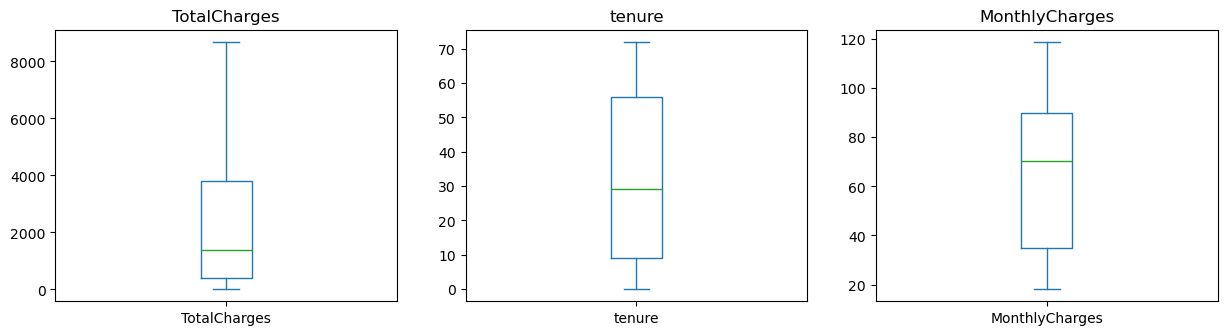

In [11]:
plt.figure(figsize=(15,12))
for i in range(len(numerical_variables)):
    plt.subplot(3,3,i+1)
    plt.title(numerical_variables[i])
    graph_data = None
    if numerical_variables[i] == 'TotalCharges':
        graph_data = churn_historic[numerical_variables[i]].apply(lambda x : parse_charges_float(x))
    else:
        graph_data = churn_historic[numerical_variables[i]]
    graph_data.plot.box()
plt.show()

Se puede observar que practicamente no existen outliers.

#### 2.4.2.3 Analíticas descriptivas

In [12]:
data = churn_historic[numerical_variables].copy()
data['TotalCharges'] = data['TotalCharges'].apply(lambda x : parse_charges_float(x))
data.describe()

,TotalCharges,tenure,MonthlyCharges
count,5990.000000,6000.000000,6000.000000
mean,2281.988155,32.320667,64.607233
std,2274.401428,24.637296,30.195382
min,18.800000,0.000000,18.250000
25%,389.337500,9.000000,35.000000
50%,1391.950000,29.000000,70.300000
75%,3803.725000,56.000000,89.850000
max,8684.800000,72.000000,118.750000


Se observa en la variable totalcharges una media casi igual a la desviación estandar y un percentil 75% considerablemente menor al máximo de los datos, lo que habla también de desbalance hacia los valores más bajos.

## 2.5 Codificación de variables categóricas

Se llevará a cabo la siguiente codificación de las variables en base a su comportamiento y distribución:

- las varaibles gender y partner tienen dos valores balanceados por lo que se aplicará un one hot encoding

- La variable SeniorCitizen tiene dos valores notoriamente desbalanceados hacia la clase 0, pero consideramos que es una variable suficientemente importante para generar cambios relevantes aún con este desbalance, además ya se encuentra codificada y se usará one hot encoding.

- La variable Dependents se encuentra desbalanceada pero no no lo suficiente para considerar retirar la columna por lo que se aplicará one hot enconding.

- La variable PhoneService tiene dos valores notoriamente desbalanceados hacia la clase true, pero consideramos que es una variable suficientemente importante para generar relevantes cambios aún con este desbalance, se aplicará one hot encoding.

- La variable multiple lines se le convertirá el no phone services en no, porque se considera que es lógico que si un cliente no tiene lineas telefónicas sea homologable con que no tiene multiples líneas telefónicas y se le aplicará one hot. Esta misma lógica se le aplicará a variables como InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV y StreamingMovies, en cuyo caso si los clientes no tienen internet, también serán catalogados como No.

- Se le aplicará OneHotEncoding a las variables Contract, PaperlessBilling, Payment method.

- A la variable objetivo churn se le aplicará binary encoding.


Argumentamos usar onehotEncoding en todos los casos porque permite ver el efecto de cada valor de las variables por separado sin que el modelo interprete alguna jerarquía, además porque la cantidad de datos es considerable mayor a la cantidad resultante de columnas, por estas razones se compensan los problemas de complejidad y overfitting que podrían ocurrir por un gran número de columnas.

## 2.6 Tratamiento de datos numéricos

Se llevará a cabo el siguiente tratamiento de los datos para variables numéricas:

- TotalCharges, convertir a float, rellenar datos vacios con la media. Emplear standardscaling

- Monthly charges y tenure usar standard scaling.

Se usa standard scaling dado a que suele funcionar en la mayoría de los casos, en caso de encontrar resultados no favorables se probará con otros escaladores.


## 2.7 Eliminar columnas innecesarias



Se eliminará la columna CustomerID, dado a que es un indentificador que no tiene nada de información acerca de nuestra variable objetivo.